<a href="https://colab.research.google.com/github/RMDircio/DS-Unit-2-Linear-Models/blob/master/Assignments/Regina%20DIrcio%20-%20Ridge%20Regression-%20213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [X] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [X] Get mean absolute error for the test set.
- [X] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

# Imports

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import category_encoders as ce
from sklearn.feature_selection import SelectKBest, f_regression
from IPython.display import display, HTML

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

# Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

In [6]:
# look at data frame

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [7]:
# make a subset

subset_df = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)]

print(subset_df.shape)
subset_df.head()

(3151, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [8]:
subset_df.isnull().sum()

BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING_CLASS_CATEGORY              0
TAX_CLASS_AT_PRESENT                 0
BLOCK                                0
LOT                                  0
EASE-MENT                         3151
BUILDING_CLASS_AT_PRESENT            0
ADDRESS                              0
APARTMENT_NUMBER                  3150
ZIP_CODE                             0
RESIDENTIAL_UNITS                    0
COMMERCIAL_UNITS                     0
TOTAL_UNITS                          0
LAND_SQUARE_FEET                     0
GROSS_SQUARE_FEET                    0
YEAR_BUILT                           0
TAX_CLASS_AT_TIME_OF_SALE            0
BUILDING_CLASS_AT_TIME_OF_SALE       0
SALE_PRICE                           0
SALE_DATE                            0
dtype: int64

#  Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test

In [9]:
# training data split
# Jan - March 2019

train_subset = subset_df[(subset_df['SALE_DATE'] >= '01/01/2019') & (subset_df['SALE_DATE'] <= '03/31/2019')]
print(train_subset.shape)
train_subset.head()

(2507, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [10]:
# test data split
# April 2019

test_subset = subset_df[(subset_df['SALE_DATE'] >= '04/01/2019') & (subset_df['SALE_DATE'] <= '04/30/2019')]
print(test_subset.shape)
test_subset.head()

(644, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
18235,2,OTHER,01 ONE FAMILY DWELLINGS,1,5913,878,NaN,A1,4616 INDEPENDENCE AVENUE,NaN,10471.0,1.0,0.0,1.0,"5,000",2272.0,1930.0,1,A1,895000,04/01/2019
18239,2,OTHER,01 ONE FAMILY DWELLINGS,1,5488,48,NaN,A2,558 ELLSWORTH AVENUE,NaN,10465.0,1.0,0.0,1.0,"2,500",720.0,1935.0,1,A2,253500,04/01/2019
18244,3,OTHER,01 ONE FAMILY DWELLINGS,1,5936,31,NaN,A1,16 BAY RIDGE PARKWAY,NaN,11209.0,1.0,0.0,1.0,"2,880",2210.0,1925.0,1,A1,1300000,04/01/2019
18280,3,OTHER,01 ONE FAMILY DWELLINGS,1,7813,24,NaN,A5,1247 EAST 40TH STREET,NaN,11210.0,1.0,0.0,1.0,"1,305",1520.0,1915.0,1,A5,789000,04/01/2019
18285,3,OTHER,01 ONE FAMILY DWELLINGS,1,8831,160,NaN,A9,2314 PLUMB 2ND STREET,NaN,11229.0,1.0,0.0,1.0,"1,800",840.0,1925.0,1,A9,525000,04/01/2019


# Do one-hot encoding of categorical features.

In [11]:
# find high cardinality features
# non numerical data

train_subset.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2507,2507,2507,2507,2507,2507,1,2507,2507,2507
unique,5,6,1,2,13,2497,1,887,11,68
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,125-27 LUCAS STREET,RP.,"4,000",A1,01/31/2019
freq,1204,2382,2507,2476,919,2,1,234,919,78


In [12]:
# drop high cardinality, target and NaNs 

target = 'SALE_PRICE'

high_cardinality = ['ADDRESS',
                    'EASE-MENT',
                    'APARTMENT_NUMBER',
                    'LAND_SQUARE_FEET',
                    'SALE_DATE']
features = train_subset.columns.drop([target] + high_cardinality)
features

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
       'BUILDING_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [0]:
# set up matrices and vectors

# training data
X_train = train_subset[features]
y_train = train_subset[target]

# test set
X_test = test_subset[features]
y_test = test_subset[target]

In [14]:
y_train

44       550000
61       200000
78       810000
108      125000
111      620000
          ...  
18129    330000
18130    690000
18132    610949
18134    520000
18147    104000
Name: SALE_PRICE, Length: 2507, dtype: int64

In [0]:
# one hot encoder

# encoding training data
encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_encode = encoder.fit_transform(X_train)

# encoding test set
X_test_encode = encoder.transform(X_test)

# Do feature selection with `SelectKBest`.

In [16]:
# select k best

selector = SelectKBest(score_func= f_regression, k=10)
X_train_k_best = selector.fit_transform(X_train_encode, y_train)
X_test_k_best = selector.transform(X_test_encode)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [17]:
# k best shapes

X_train_k_best.shape, X_test_k_best.shape

((2507, 10), (644, 10))

In [19]:
# k best columns used

mask = selector.get_support()
X_train_encode.columns[mask]

Index(['BOROUGH_3', 'BOROUGH_2', 'BOROUGH_5', 'NEIGHBORHOOD_OTHER',
       'NEIGHBORHOOD_FLUSHING-NORTH', 'NEIGHBORHOOD_FOREST HILLS',
       'BUILDING_CLASS_AT_PRESENT_A3', 'ZIP_CODE', 'GROSS_SQUARE_FEET',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A3'],
      dtype='object')

In [20]:
# k best column not used

X_train_encode.columns[~mask]

Index(['BOROUGH_4', 'BOROUGH_1', 'NEIGHBORHOOD_BEDFORD STUYVESANT',
       'NEIGHBORHOOD_BOROUGH PARK', 'NEIGHBORHOOD_ASTORIA',
       'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
       'TAX_CLASS_AT_PRESENT_1', 'TAX_CLASS_AT_PRESENT_1D', 'BLOCK', 'LOT',
       'BUILDING_CLASS_AT_PRESENT_A9', 'BUILDING_CLASS_AT_PRESENT_A1',
       'BUILDING_CLASS_AT_PRESENT_A5', 'BUILDING_CLASS_AT_PRESENT_A0',
       'BUILDING_CLASS_AT_PRESENT_A2', 'BUILDING_CLASS_AT_PRESENT_S1',
       'BUILDING_CLASS_AT_PRESENT_A4', 'BUILDING_CLASS_AT_PRESENT_A6',
       'BUILDING_CLASS_AT_PRESENT_A8', 'BUILDING_CLASS_AT_PRESENT_B2',
       'BUILDING_CLASS_AT_PRESENT_S0', 'BUILDING_CLASS_AT_PRESENT_B3',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE_A9',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A0',
       'BUILDING_CLASS_AT_TIME

# Fit a ridge regression model with multiple features. Use the `normalize=True` parameter

In [45]:
from sklearn.linear_model import RidgeCV
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge = RidgeCV(alphas=alphas, normalize=True)
ridge.fit(test_subset[['x']], subset_df['y'])
ridge.alpha_

KeyError: ignored

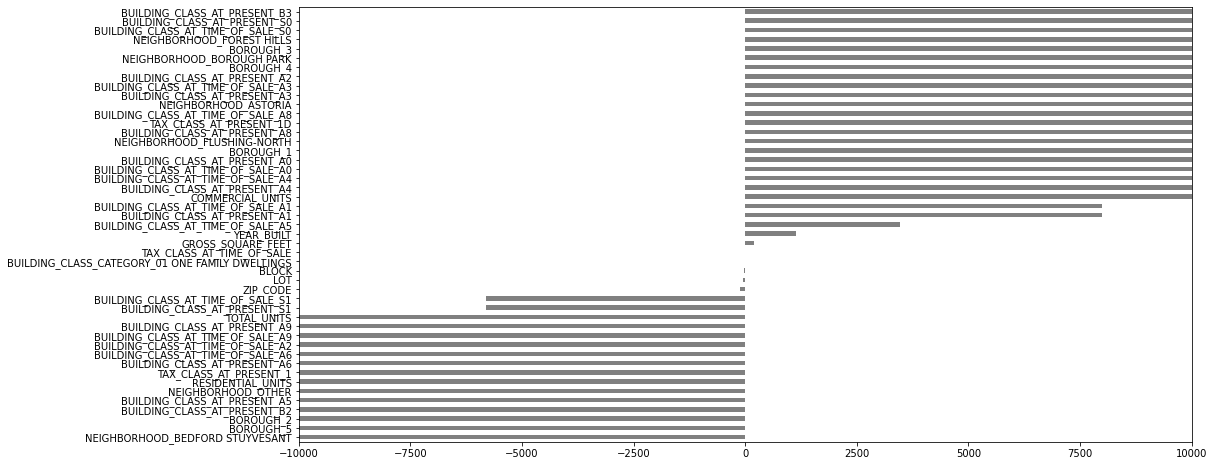

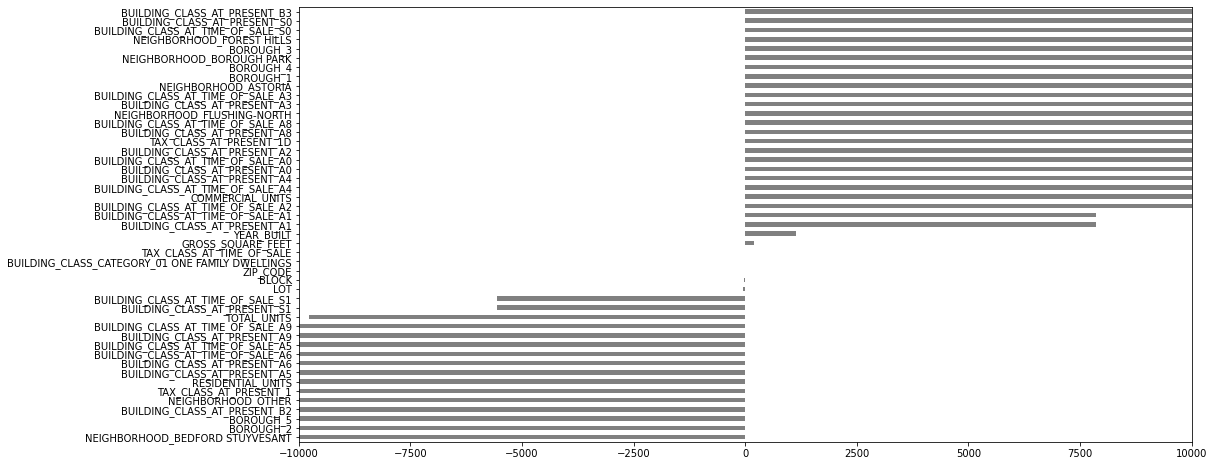

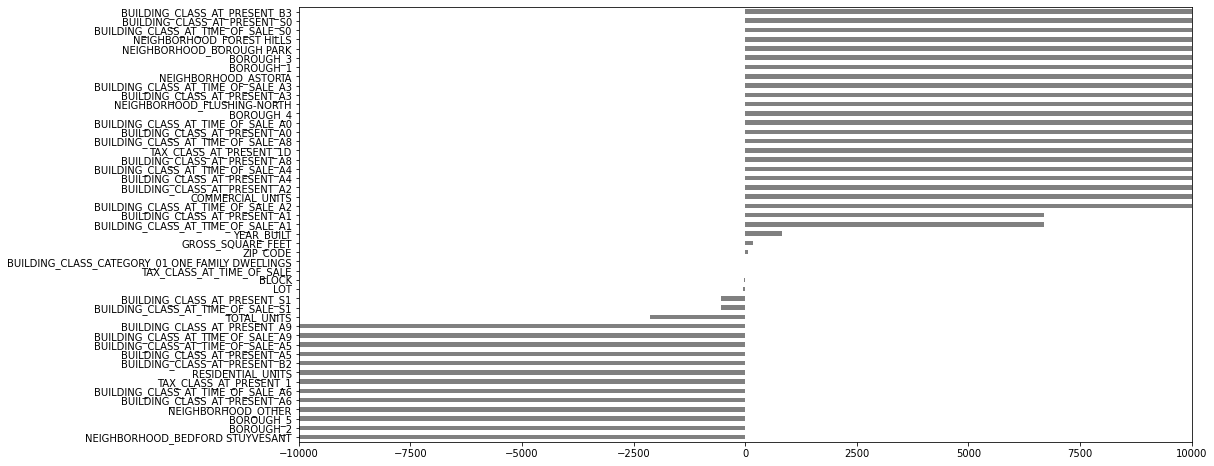

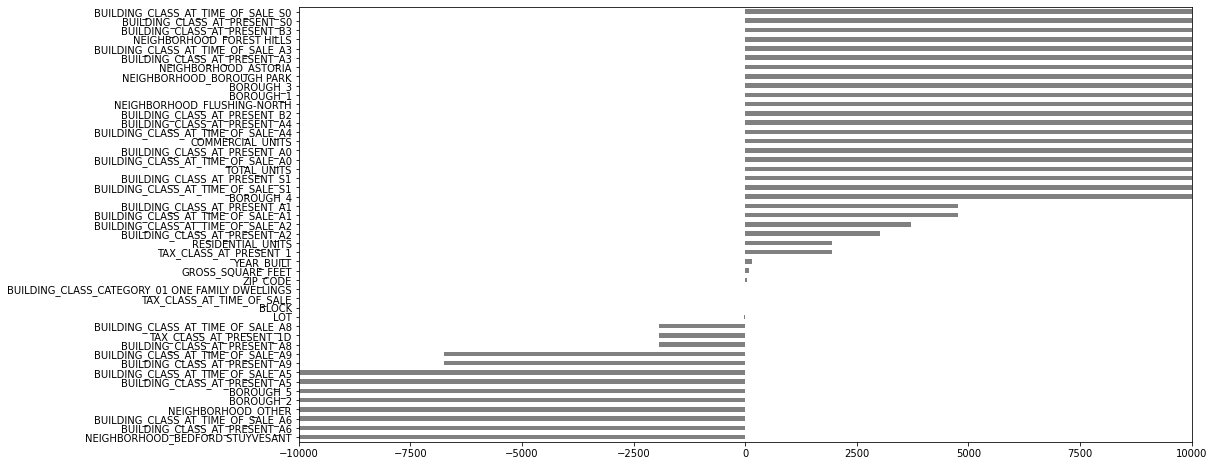

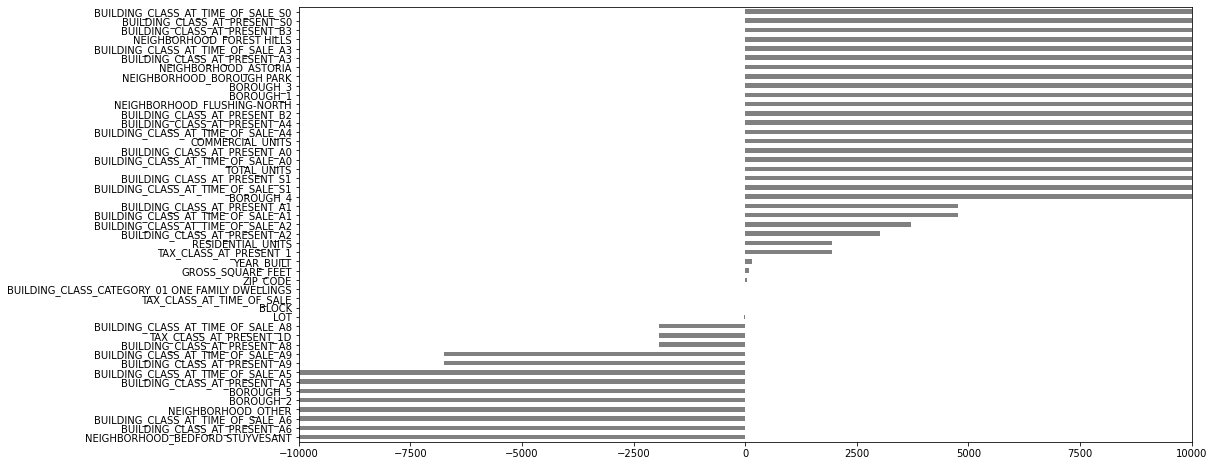

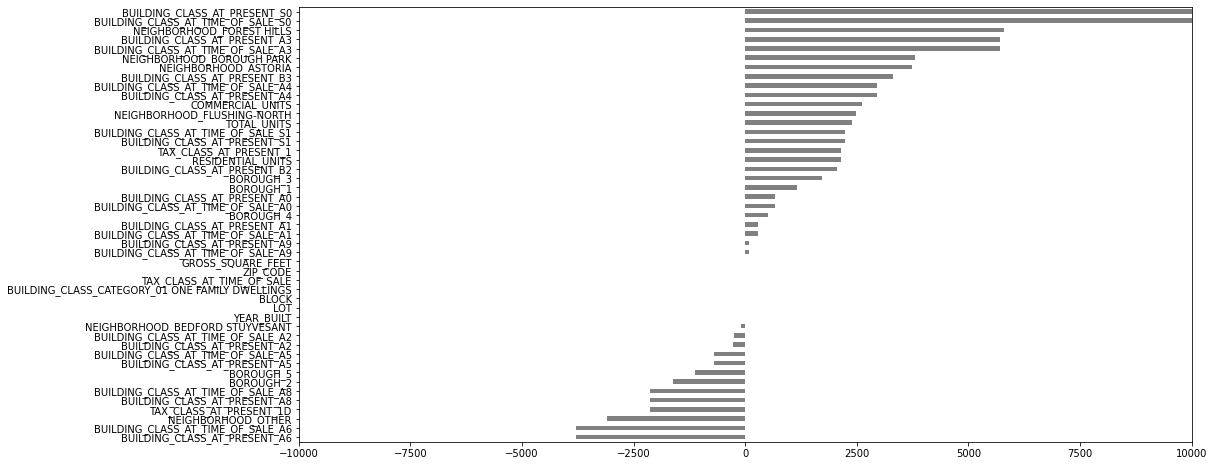

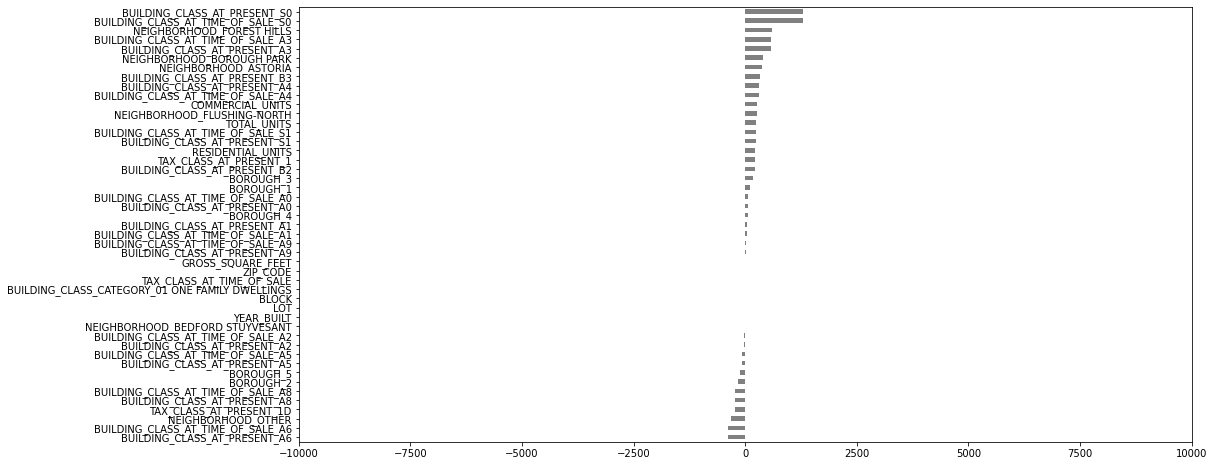

In [47]:
from IPython.display import display, HTML
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:

  # ridge regression
  display(HTML(f'Ridge Regression, with alpha={alpha}'))
  model = Ridge(alpha=alpha, normalize=True)
  model.fit(X_train_encode, y_train)
  y_predict = model.predict(X_test_encode)

  # mean absolute error on test set
  mae = mean_absolute_error(y_test, y_predict)
  display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))

  # plot coefficients
  coefficients = pd.Series(model.coef_, X_train_encode.columns)
  plt.figure(figsize=(16,8))
  coefficients.sort_values().plot.barh(color='grey')
  plt.xlim(-10000,10000)
  plt.show()

# Get mean absolute error for the test set.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# mean absolute error

mae_list = []
for k in range(1, X_train_encode.shape[1]+1):
  print(f'{k} features')
  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_k_best = selector.fit_transform(X_train_encode, y_train)
  X_test_k_best = selector.transform(X_test_encode)
  model = LinearRegression()
  model.fit(X_train_k_best, y_train)
  y_predict = model.predict(X_test_k_best)
  mae = mean_absolute_error(y_predict, y_test)
  print(f'MAE on test set: ${mae:.2f}')
  mae_list.append(mae)

1 features
MAE on test set: $183640.59
2 features
MAE on test set: $182569.26
3 features
MAE on test set: $182569.26
4 features
MAE on test set: $173706.26
5 features
MAE on test set: $174555.83
6 features
MAE on test set: $172842.63
7 features
MAE on test set: $173412.45
8 features
MAE on test set: $173241.27
9 features
MAE on test set: $168667.79
10 features
MAE on test set: $169452.34
11 features
MAE on test set: $169006.25
12 features
MAE on test set: $161221.08
13 features
MAE on test set: $162577.98
14 features
MAE on test set: $161733.50
15 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

MAE on test set: $161734.70
16 features
MAE on test set: $161547.70
17 features
MAE on test set: $161547.70
18 features
MAE on test set: $161308.08
19 features
MAE on test set: $161308.08
20 features
MAE on test set: $159302.63
21 features
MAE on test set: $159370.94
22 features
MAE on test set: $159370.94
23 features
MAE on test set: $159370.94
24 features
MAE on test set: $159370.94
25 features
MAE on test set: $159106.73
26 features
MAE on test set: $158989.99
27 features
MAE on test set: $158924.19
28 features
MAE on test set: $158881.96
29 features
MAE on test set: $159682.57
30 features
MAE on test set: $159733.68
31 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

MAE on test set: $159733.68
32 features
MAE on test set: $159311.20
33 features
MAE on test set: $159288.88
34 features
MAE on test set: $159292.42
35 features
MAE on test set: $158950.72
36 features
MAE on test set: $158950.72
37 features
MAE on test set: $159749.11
38 features
MAE on test set: $159206.93
39 features
MAE on test set: $159255.62
40 features
MAE on test set: $159269.84
41 features
MAE on test set: $159601.74
42 features
MAE on test set: $159560.87
43 features
MAE on test set: $159556.67
44 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered

MAE on test set: $159551.92
45 features
MAE on test set: $159526.77
46 features
MAE on test set: $159563.49
47 features
MAE on test set: $159556.78


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered